In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import r2_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.api as sm

In [3]:
import shap

In [4]:
from sklearn.feature_selection import SelectFromModel

In [5]:
religion_feats = ['Catholic Church', 'Buddhism', 'Atheism']
interest_feats = ['Gambling', 'Casino', 'Cooking', 'Restaurants',  'Fast food', 'Fitness and wellness',  'LGBT community','Homosexuality', 'Same-sex marriage']

In [6]:
# Number of trees in random forest
n_estimators_list = [10, 50, 100, 200, 300]
# Maximum number of levels in tree
max_depth_list = [2, 5, 20, 50, 100]
# max_depth_list.append(None)
# Minimum number of samples required to split a node
min_samples_split_list = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf_list = [1]

# ALL AGES

In [7]:
df = pd.read_csv('data/santiago/santiago_all_ages_normalized_average_query_withnans.csv').drop(labels=['Unnamed: 0'], axis=1).dropna()
df = df[(df.comuna_id < 13200) & (df.comuna_id!=13115)].reset_index(drop=True)

In [8]:
zips = (df.loc[:,'Users':'Windows']!=0).sum(axis=1)>0
df = df[zips]

In [9]:
features = df.loc[:,'Users':].columns[(df.loc[:,'Users':]!=0).sum(axis=0) > 0]
df = df[features]

In [10]:
rs = np.random.RandomState(seed=0)
np_income = df.median_income_comuna + rs.rand(df.median_income_comuna.shape[0])

In [11]:
for q in [25, 50, 75]:
    df['median_income_comunaq%d'%q] = (np_income > np.percentile(np_income, q)).astype(int)
    print(df['median_income_comunaq%d'%q].sum()/df['median_income_comunaq%d'%q].shape[0])

0.7419354838709677
0.4838709677419355
0.25806451612903225


In [12]:
feats = df.loc[:,~df.columns.isin(interest_feats+religion_feats)].loc[:, 'Males':'Windows'].columns
X = df.loc[:,~df.columns.isin(interest_feats+religion_feats)].loc[:, 'Males':'Windows'].values
y_true = df['median_income_comuna'].values

In [13]:
best_best = []

rs = np.random.RandomState(42)

for q_train in [50]:
    
    best_qs = []

    y = df['median_income_comunaq%d'%q_train].values
    
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            for min_samples_split in min_samples_split_list:
                for min_samples_leaf in min_samples_leaf_list:

                    params = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                    rfc = RandomForestClassifier(n_estimators=n_estimators,
                                                  max_depth=max_depth, 
                                                  min_samples_split=min_samples_split,
                                                  min_samples_leaf=min_samples_leaf, random_state=rs)                    
                    
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
                    cv_folds = list(cv.split(X,y))
                    model = make_pipeline(StandardScaler(), rfc)

                    y_probs = cross_val_predict(model, X, y, cv=cv_folds, method='predict_proba')
            
                    auc = roc_auc_score(y, y_probs[:,1])
                    best_qs.append((auc, params, q_train))

    best_q = sorted([b for b in best_qs if ~np.isnan(b[0])], key= lambda x: x[0], reverse=True)[0]
    best_best.append(best_q)
    
best_best = sorted([b for b in best_best if ~np.isnan(b[0])], key= lambda x: x[0], reverse=True)
    
for best_ in best_best:
                    
    print('auc: %.3f' % best_[0], best_[1][:2], best_[2])

auc: 0.950 [50, 2] 50


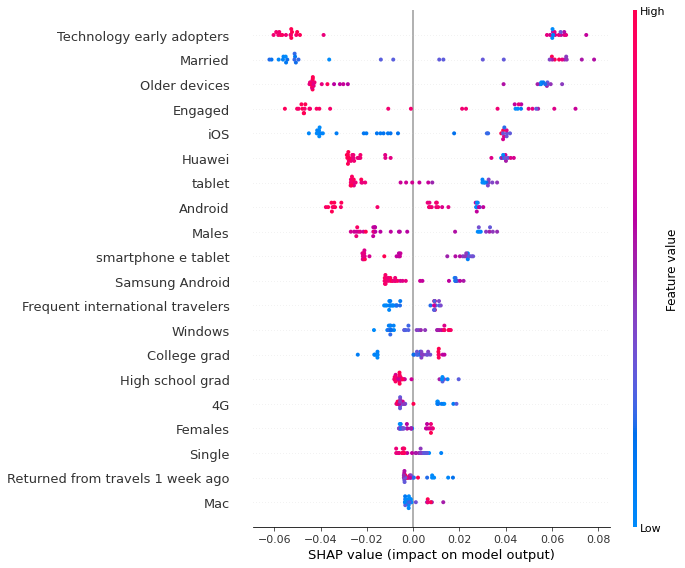

In [14]:
y = df['median_income_comunaq%d'%best_best[0][2]].values
shap_values_list = []

for seed in range(30):

    rfc = RandomForestClassifier(n_estimators=best_best[0][1][0],
                                  max_depth=best_best[0][1][1], 
                                  min_samples_split=2,
                                  min_samples_leaf=1, random_state=seed).fit(StandardScaler().fit_transform(X), y)

    explainer = shap.TreeExplainer(rfc)
    shap_values = explainer.shap_values(StandardScaler().fit_transform(X))
    shap_values_list.append(shap_values[1])

shap.summary_plot(np.array(shap_values_list).mean(axis=0), features=StandardScaler().fit_transform(X), feature_names=feats,
                 plot_type='dot', show=False)
plt.savefig('figures/santiago_all_ages_shap_auc.pdf', facecolor='white', bbox_inches='tight')